In [1]:
!pip install pandas
!pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

df = pd.read_csv('train_1.csv')
df.head()

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [3]:
#train = df.drop('Page', axis=1)
#row = train.iloc[90000,:].values
#X = row[0:549]
#y = row[1:550]
#print(X)

In [4]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2016-12-31


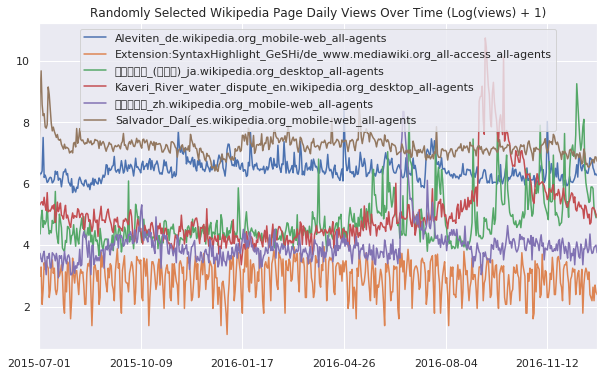

In [5]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    page_labels = sample['Page'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(df, 6)

### Train and Validation Series Partioning


In [6]:
from datetime import timedelta

pred_steps = 14
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date)
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day
print(val_pred_start, val_pred_end)

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)
print(train_pred_start, train_pred_end)


2016-12-18 00:00:00 2016-12-31 00:00:00
2016-12-04 00:00:00 2016-12-17 00:00:00


In [7]:
enc_length = train_pred_start - first_day
print(enc_length)

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)
print(train_enc_start, train_enc_end)
print(val_enc_start, val_enc_end)

522 days 00:00:00
2015-07-01 00:00:00 2016-12-03 00:00:00
2015-07-15 00:00:00 2016-12-17 00:00:00


In [8]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-07-01 00:00:00 - 2016-12-03 00:00:00
Train prediction: 2016-12-04 00:00:00 - 2016-12-17 00:00:00 

Val encoding: 2015-07-15 00:00:00 - 2016-12-17 00:00:00
Val prediction: 2016-12-18 00:00:00 - 2016-12-31 00:00:00

Encoding interval: 522
Prediction interval: 14


## Data Formatting

In [9]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values.astype(np.float32)
print(series_array)

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1)
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))

    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))    
    
    return series_array

[[18. 11.  5. ... 19. 18. 20.]
 [11. 14. 15. ... 45. 26. 20.]
 [ 1.  0.  1. ...  3.  4. 17.]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [10]:
first_n_samples = 20000
batch_size = 2**11
epochs = 100
# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]


encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)


# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]

decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)


encoder_input_val_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_val_data, encode_series_mean = transform_series_encode(encoder_input_val_data)

decoder_target_val_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_val_data = transform_series_decode(decoder_target_val_data, encode_series_mean)

#for d in encoder_input_data:
#    print(d.shape)

#train_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data, decoder_target_data))
#train_dataset = train_dataset.batch(54)

#for d in train_dataset:
#    #print(f'features:{features_tensor} target:{target_tensor}')
#    print("-----")
#    print(d)

### Transformer model

In [3]:
!pip install tensorflow_datasets

import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
     |################################| 686kB 20.5MB/s eta 0:00:01
     |################################| 440kB 32.5MB/s eta 0:00:01
     |################################| 829kB 28.4MB/s eta 0:00:01
     |################################| 51kB 22.9MB/s eta 0:00:01
     |################################| 153kB 30.5MB/s eta 0:00:01
  Stored in directory: /home1/www/.cache/pip/wheels/17/08/ec/22b464874958c3fc91e1a75748fae2220eb704a8b1035f9a03
  Stored in directory: /home1/www/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
  Stored in directory: /home1/www/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
  Stored in directory: /home1/www/.cache/pip/wheels/5b/d7/0f/e58eae695403de585269f4e4a94e0cd6ca60ec0c202936fa4a
  Sto

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data, decoder_target_data))
val_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_val_data, decoder_target_val_data))

In [13]:
### position
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
  
    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])
  
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)


In [14]:
# Masking
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions so that we can add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
print(create_padding_mask(x))

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 4))
temp = create_look_ahead_mask(x.shape[1])
print(temp)


tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)
tf.Tensor(
[[0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]], shape=(4, 4), dtype=float32)


In [15]:
# Scaled dot product attention
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.
  
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth)
        mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_v, depth)

    return output, attention_weights

In [16]:
# scaled dot product attetion test
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
        q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 3)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [17]:
# Multi Head Attention

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v) # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size) #(batch_size, num_head, seq_len_v, depth)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_v, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_v, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_v, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_v, d_model)
        
        return output, attention_weights
    

In [18]:
# multhead attention test
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape


(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [19]:
# Point wise feed forward network
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


In [20]:
# Point wise feed forward network test
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

### Encoder and Decoder

In [21]:
# Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) # (batch_size, input_seq_len, d_model)
        
        return out2

In [22]:
# Encoder Layer Test
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)


TensorShape([64, 43, 512])

In [23]:
# Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
                                            
    def call(self, x, enc_output, training,
            look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2
    
    

In [24]:
# Decoder layer test
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [25]:
# Encoder

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000,
                rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # adding embedding and position encoding
        x = self.embedding(x)
        # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x
                          

In [26]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 62,1)), 
                                       training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [27]:
# Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
    
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training,
                look_ahead_mask, padding_mask):
        
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                  look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        
        
        return x, attention_weights
    


In [28]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048)

output, attn = sample_decoder(tf.random.uniform((64, 26,3)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

### Transfomer for TS


In [29]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, out_dim, max_len=5000,
                rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                              max_len, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               max_len, rate)
        
        self.final_layer = tf.keras.layers.Dense(out_dim)
        
    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights
    
    

In [30]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    out_dim=1)

temp_input = tf.random.uniform((64, 62,1))
temp_target = tf.random.uniform((64, 23,1))

fn_out, _ = sample_transformer(temp_input, temp_target,training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape

TensorShape([64, 23, 1])

In [31]:
# Set hyperparameters

num_layers = 1
d_model = 64
dff = 256
num_heads = 4

dropout_rate = 0.2
input_sequence_length = 522 # Length of the sequence used by the encoder
target_sequence_length = 14 # Length of the sequence predicted by the decoder
batch_size = 2*11

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [7]:
# Optimizizer
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [12]:
learning_rate = CustomSchedule(64)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5,0,'Train Step')

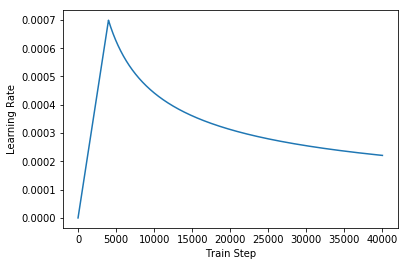

In [15]:
temp_learning_rate_schedule = CustomSchedule(512)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [35]:
# Loss and metrics
loss_object = tf.keras.losses.MeanAbsoluteError()

In [36]:
def loss_function(real, pred):
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_mean(loss_)


In [37]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
#train_accuracy = tf.keras.metrics.mean_absolute_error()

test_loss = tf.keras.metrics.Mean(name='test_loss')

In [38]:
# Training and checkpoint
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          out_dim=1, rate=dropout_rate)

In [39]:
def create_masks(inp, tar):
    inp = inp.reshape()
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
  
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
  
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [40]:
# check point
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    

In [41]:
# EPOCHS
EPOCHS=100


In [42]:
@tf.function
def train_step(inp, tar):
    last_inp = tf.expand_dims(inp[:,0,:],-1)
    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar
  
    #enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    #print(enc_padding_mask)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     None, 
                                     look_ahead_mask, 
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    #train_accuracy(tar_real, predictions)

In [43]:
@tf.function
def test_step(inp, tar):
    #print(inp)
    #print(tar)
    last_inp = tf.expand_dims(inp[:,0,:],-1)
    #print(last_inp)
    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    predictions, _ = transformer(inp, tar_inp, 
                                     False, 
                                     None, 
                                     look_ahead_mask, 
                                     None)
    loss = loss_function(tar_real, predictions)
    test_loss(loss)

In [44]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    test_loss.reset_states()
    #train_accuracy.reset_states()
  
    for (batch, (inp, tar)) in enumerate(train_dataset):
        #print(tf.shape(inp))
        train_step(inp, tar)
    
        #if batch % 100 == 0:
        #    print ('Epoch {} Batch {} Train Loss {:.4f} '.format(
        #        epoch + 1, batch, train_loss.result()))
                #, train_accuracy.result()))
    
    # validation:
    #for (batch, (inp, tar)) in enumerate(val_dataset):
        #print(inp, tar)
    #    test_step(inp, tar)
        
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    print ('Epoch {} Train Loss {:.4f}'.format(epoch + 1, 
                                                train_loss.result())) 
                                                #train_accuracy.result()))
    #print ('Epoch {} Test Loss {:.4f}'.format(epoch + 1, 
    #                                      test_loss.result())) 
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    


Epoch 1 Train Loss 1.3482
Time taken for 1 epoch: 41.2856981754303 secs

Epoch 2 Train Loss 0.4032
Time taken for 1 epoch: 28.55569076538086 secs

Epoch 3 Train Loss 0.3388
Time taken for 1 epoch: 28.369380950927734 secs

Epoch 4 Train Loss 0.3109
Time taken for 1 epoch: 28.787972927093506 secs

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-1
Epoch 5 Train Loss 0.2976
Time taken for 1 epoch: 29.209737539291382 secs

Epoch 6 Train Loss 0.2929
Time taken for 1 epoch: 29.032524824142456 secs

Epoch 7 Train Loss 0.2892
Time taken for 1 epoch: 28.489789724349976 secs

Epoch 8 Train Loss 0.2849
Time taken for 1 epoch: 28.46707320213318 secs

Epoch 9 Train Loss 0.2829
Time taken for 1 epoch: 28.831282377243042 secs

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Epoch 10 Train Loss 0.2802
Time taken for 1 epoch: 28.659141063690186 secs

Epoch 11 Train Loss 0.2783
Time taken for 1 epoch: 29.24239230155945 secs

Epoch 12 Train Loss 0.2780
Time taken for 1 epoch: 29.004

Saving checkpoint for epoch 95 at ./checkpoints/train/ckpt-19
Epoch 95 Train Loss 0.2592
Time taken for 1 epoch: 28.521962881088257 secs

Epoch 96 Train Loss 0.2591
Time taken for 1 epoch: 28.37543249130249 secs

Epoch 97 Train Loss 0.2591
Time taken for 1 epoch: 28.339919805526733 secs

Epoch 98 Train Loss 0.2589
Time taken for 1 epoch: 28.298816442489624 secs

Epoch 99 Train Loss 0.2592
Time taken for 1 epoch: 28.176313877105713 secs

Saving checkpoint for epoch 100 at ./checkpoints/train/ckpt-20
Epoch 100 Train Loss 0.2590
Time taken for 1 epoch: 28.3803813457489 secs



In [45]:
MAX_LENGTH = target_sequence_length

def evaluate(inp):
    encoder_input = inp
    #print(encoder_input)
    output = tf.expand_dims(encoder_input[:,-1,:],-1)
    #print(output)
    
    for i in range(MAX_LENGTH):
        look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])
        predictions, attention_weights = transformer(encoder_input, 
                                                     output, 
                                                     False, 
                                                     None, 
                                                     look_ahead_mask, 
                                                     None)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1)
        #print("pred:", predictions) #
        output = tf.concat([output, predictions], axis=1)
        #print(output)
        
    return tf.squeeze(output, axis=0), attention_weights

In [46]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    #print(encode_series)
    
    pred_series, _ = evaluate(encode_series)
    pred_series = np.array([pred_series])
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)[1:,:]   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

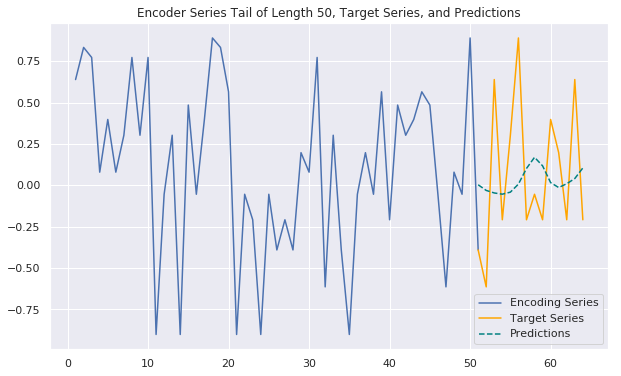

In [47]:
predict_and_plot(encoder_input_val_data, decoder_target_val_data, 100)

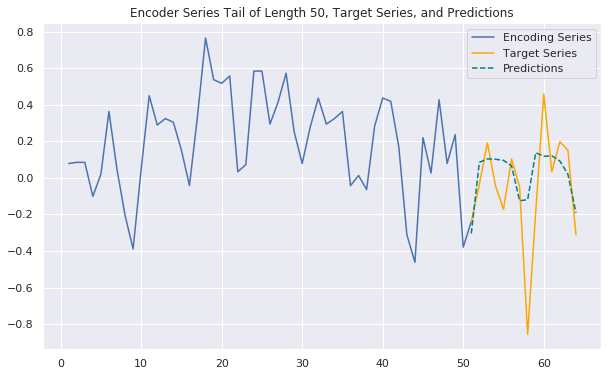

In [48]:
predict_and_plot(encoder_input_val_data, decoder_target_val_data, 6007)

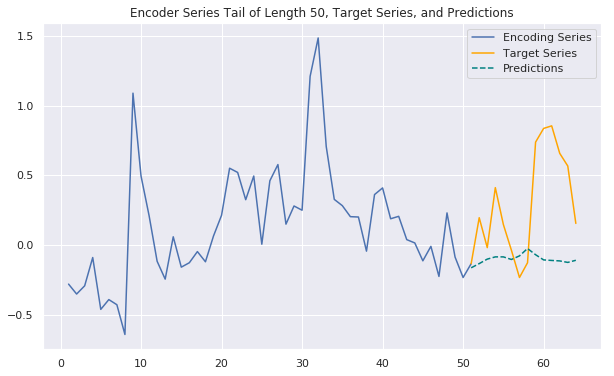

In [49]:
predict_and_plot(encoder_input_val_data, decoder_target_val_data, 30003)

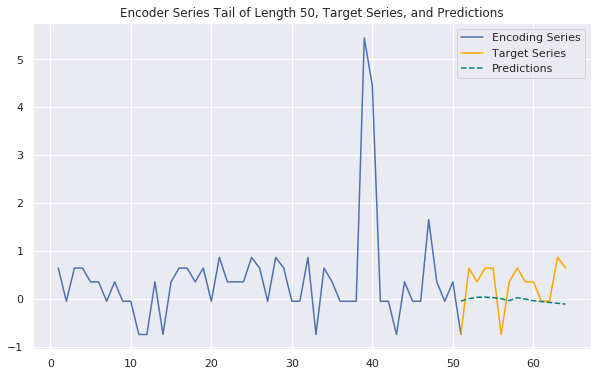

In [50]:
predict_and_plot(encoder_input_val_data, decoder_target_val_data, 33000)